# 1. Introdução
------
Este notebook tem por objetivo ensinar como utilizar a biblioteca do GPA, além de apresentar alguns testes de matrizes fundamentais. 


Rode a célula a seguir, caso essteja utilizando o colab

In [ ]:
!pip install git+https://github.com/rsautter/GPA

A célula a seguir invoca as bibliotecas de manipulação de vetores, plotagem e o próprio GPA 

In [1]:
import GPA
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import matplotlib.patches as mpatches

# 2. Utilizando o GPA
------
O GPA foi implementado como um objeto que analisa matrizes. Há um parâmetro de tolerância que é fornecido ao método construtor do GPA. 

No exemplo a seguir, a tolerância é zero, porém qualquer medida entre zero e um pode ser considerada. Este parâmetro determina a partir do maior vetor no padrão a ser analisado qual a tolerância do algoritmo de detecção de simetria.

In [3]:
ga = GPA.GPA(0.08)

O dado a ser analisado deve ser um array da biblioteca numpy e do tipo float, caso contrário ocorrerá um erro.

In [4]:
mat = [[0,0,0],
       [0,1,0],
       [0,0,0]]
mat = np.array(mat).astype(np.float)

O método 'evaluate' realiza a medida dos momentos do campo gradiente. Há três parâmetros:

 - mat - A matriz de entrada do tipo float
 - moment - Lista de momentos do campo gradiente a serem medidos ('G1','G2','G3' ou 'G4')
 - symmetrycalGrad - Determina se a medida será realizada sobre o campo simétrico

Por padrão os parâmetros são:

    moment = ['G2']
    symmetrycalGrad = 0

Neste exemplo a matriz é completamente simétrica.

In [5]:
moments = ga.evaluate(mat, moment=['G1','G2','G3'],symmetrycalGrad=0)
print("Momentos do campo gradiente assimétrico:",np.round(moments,3))

moments = ga.evaluate(mat, moment=['G1','G2','G3'],symmetrycalGrad=1)
print("Momentos do campo gradiente simétrico:",np.round(moments,3))

Momentos do campo gradiente assimétrico: [0. 0. 0.]
Momentos do campo gradiente simétrico: [0.25 2.   1.  ]


## 2.1. Momentos do Campo Gradiente

###  Primeiro Momento  do Campo Gradiente ($G_1$)
O primeiro momento do campo gradiente é calculado a partir da triangulação de Delaunay. A medida é a razão entre o número de conexões ($N_C$) em relação ao número de vetores ($N_V$). Por meio de testes [(ROSA et. al., 1999)](https://www.worldscientific.com/doi/abs/10.1142/S0129183199000103), foi constatado que a medida está limitada ao intervalo \[0, 2\[.   

$$G_1 = {N_C-N_V \over N_V} = {N_C \over N_V}-1$$

Não há impedimentos de $G_1$ quanto a classificação do campo gradiente em relação a simetria, o que não é observado para os casos do segundo e terceiro momentos do campo gradiente.

### Segundo Momento do Campo Gradiente Assimétrico ($G_2$)
O segundo momento do campo gradiente é uma medida que relacionada a proporção de vetores assimétricos(${V_A / V}$) e a variabilidade dos módulos ($ {|\sum v^A| / \sum|v^A|}$) . Esta medida foi ajustada ao intervalo $[0,2]$, conforme descrito por [Barchi, et.al.,(2017)](https://arxiv.org/abs/1705.06818), com o intuito de comparar aos demais momentos do campo gradiente.

$$ G_2 = {V_A \over V} \left( 2 - {|\sum v^A|\over \sum|v^A|}\right)$$

### Segundo Momento do Campo Gradiente Simétrico ($G^S_2$)
Infelizmente, a medida utilizada no segundo momento do campo gradiente assimétrico não pode ser utilizada para o caso do campo simétrico. O somatório de vetores simétricos é sempre zero ($|\sum v^S| = 0$), e portanto a medida seria apenas uma proporção de vetores. Como alternativa, é proposto a equação a seguir, onde $||v^S_{i,j}||$ é o módulo de um determinado vetor simétrico, normalizado pelo maior módulo de vetor simétrico.

$$G^S_2 = -2 \sum ||v^S||ln\left(||v^S||\right)$$
 
###  Terceiro Momento do Campo Gradiente ($G_3$)

O terceiro momento é uma medida das fases do campo gradiente. A medida proposta para o terceiro momento pondera se os vetores estão direcionados para o centro da matriz. Para tanto, o produto interno entre os vetores unitários do vetor e a localização espacial do vetor. Na equação a seguir $\theta^A_i$ é a fase do campo gradiente, enquanto $\phi^A_i$ é o ângulo entre o centro do padrão e a localização do vetor. 

$$G_3 = {V_A \over V} + {1 \over 2 V_A}\sum_i^{V_A} cos(\theta^A_i)cos(\phi^A_i)+sin(\theta^A_i)sin(\phi^A_i)+1$$

## 2.2. Plot


O plot a seguir mostra a matriz de amplitudes, o campo gradiente e a classificação dos vetores quanto a simetria. Infelizmente, para o caso de um padrão somente com vetores indeterminados, como uma matriz constante, a função [quiver](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.quiver.html) não funciona propriamente.

Outro aspecto importante é que por padrão matrizes numpy possuem origem no canto superior esquerdo, enquanto o padrão da matplotlib a origem é o canto inferior equerdo.

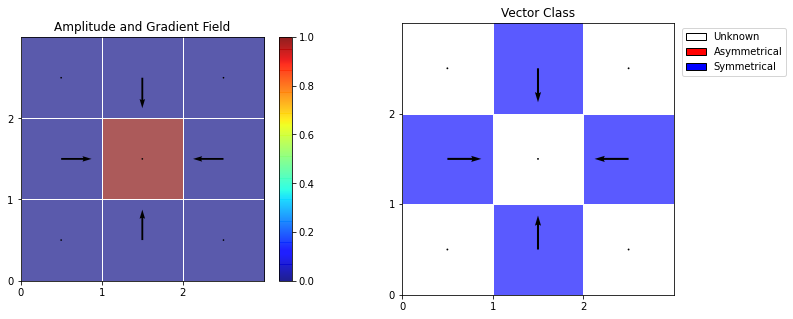

In [6]:
def plotGPAVecClass(mat,ga):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    im = plt.imshow(mat,origin='lower',alpha=0.65,cmap = 'jet',extent=[0,len(mat),0,len(mat)])
    plt.colorbar(im,shrink=0.9)
    meshgrid = np.meshgrid(np.arange(0,len(mat))+.5,np.arange(0,len(mat))+.5)
    plt.quiver(meshgrid[0],meshgrid[1],ga.gradient_dx,ga.gradient_dy)
    plt.gca().set_xticks(np.arange(0, len(mat)), minor=False)
    plt.gca().set_yticks(np.arange(0,  len(mat)), minor=False)
    plt.gca().grid(which='major', color='w', linestyle='-', linewidth=1)
    plt.title("Amplitude and Gradient Field")
    plt.subplot(1,2,2)
    classificationMap = np.array(ga.unknownP) + 3*np.array(ga.asymmetricalP) + 5*np.array(ga.symmetricalP) 
    
    cmap = colors.ListedColormap(['white','red','blue'])
    norm = colors.BoundaryNorm([0,2,5,6], cmap.N)
    plt.imshow(classificationMap,origin='lower',cmap=cmap,extent=[0,len(mat),0,len(mat)],alpha=0.65,norm=norm)
    plt.quiver(meshgrid[0],meshgrid[1],ga.gradient_dx,ga.gradient_dy)
    plt.gca().set_xticks(np.arange(0, len(mat)), minor=False)
    plt.gca().set_yticks(np.arange(0,  len(mat)), minor=False)
    plt.gca().grid(which='major', color='w', linestyle='-', linewidth=1)
    legendColors = [mpatches.Patch(facecolor='white', label='Unknown', edgecolor='k'),
                    mpatches.Patch(facecolor='red', label='Asymmetrical', edgecolor='k'),
                    mpatches.Patch(facecolor='blue', label='Symmetrical', edgecolor='k')]
    plt.legend(handles=legendColors, bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.title("Vector Class")
    plt.show()
    
plotGPAVecClass(mat,ga)

# 3. Matrizes Fundamentais
------

O conceito original de matriz fundamental foi estabelecido por [Rosa et. al., (1999)](https://www.worldscientific.com/doi/abs/10.1142/S0129183199000103), como a menor matriz que possui um elemento central, ou seja uma matriz fundamental 2D possui tamanho 3x3. Este tipo de padrão é importante para entender os algoritmos propostos e validar a implementação.


Neste sentido, são apresentados quatro categorias de matrizes fundamentais:

    - simétricas
    - assimétricas
    - misto entre simetria e assimetria
    - indeterminado
    

## 3.1. Simétrica

In [7]:
mat = [[0,2,0],
       [2,1,2],
       [0,2,0]]
mat = np.array(mat).astype(np.float)
moments = ga.evaluate(mat, moment=['G1','G2','G3'],symmetrycalGrad=0)
print("Momentos do campo gradiente assimétrico:",np.round(moments,3))

moments = ga.evaluate(mat, moment=['G1','G2','G3'],symmetrycalGrad=1)
print("Momentos do campo gradiente simétrico:",np.round(moments,3))

Momentos do campo gradiente assimétrico: [0. 0. 0.]
Momentos do campo gradiente simétrico: [0.    1.886 1.5  ]


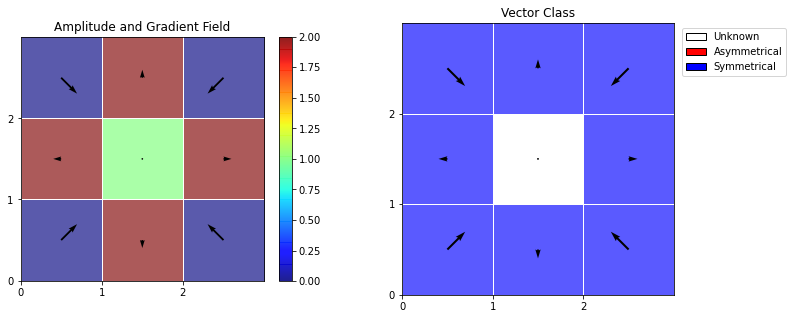

In [8]:
plotGPAVecClass(mat,ga)

In [9]:
mat = [[3,6,4],
       [6,0,6],
       [4,6,3]]
mat = np.array(mat).astype(np.float)
moments = ga.evaluate(mat, moment=['G1','G2','G3'],symmetrycalGrad=0)
print("Momentos do campo gradiente assimétrico:",np.round(moments,3))

moments = ga.evaluate(mat, moment=['G1','G2','G3'],symmetrycalGrad=1)
print("Momentos do campo gradiente simétrico:",np.round(moments,3))

Momentos do campo gradiente assimétrico: [0. 0. 0.]
Momentos do campo gradiente simétrico: [0.75  1.96  1.499]


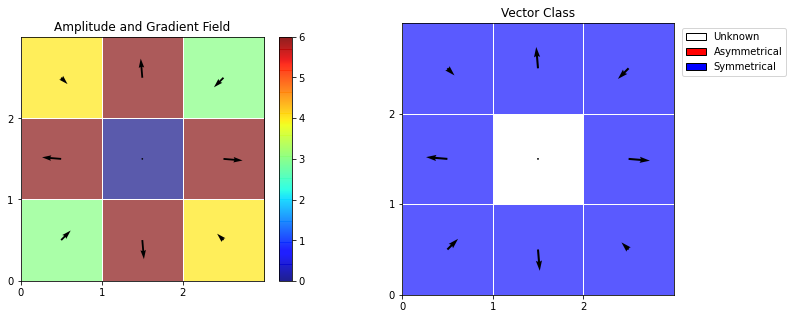

In [10]:
plotGPAVecClass(mat,ga)

## 3.2. Assimétrico

In [11]:
mat = [[3,6,4],
       [6,0,6],
       [4,7,4]]
mat = np.array(mat).astype(np.float)
moments = ga.evaluate(mat, moment=['G1','G2','G3'],symmetrycalGrad=0)
print("Momentos do campo gradiente assimétrico:",np.round(moments,3))

moments = ga.evaluate(mat, moment=['G1','G2','G3'],symmetrycalGrad=1)
print("Momentos do campo gradiente simétrico:",np.round(moments,3))

Momentos do campo gradiente assimétrico: [0.667 1.019 1.086]
Momentos do campo gradiente simétrico: [0.    2.    1.249]


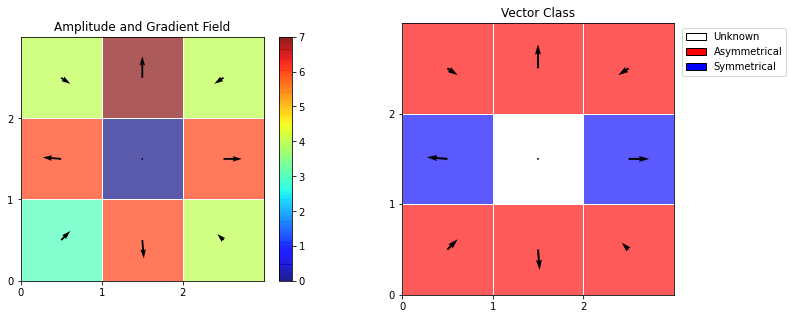

In [12]:
plotGPAVecClass(mat,ga)

## 3.3. Misto

In [13]:
mat = [[3,6,5],
       [6,0,6],
       [4,6,3]]
mat = np.array(mat).astype(np.float)
moments = ga.evaluate(mat, moment=['G1','G2','G3'],symmetrycalGrad=0)
print("Momentos do campo gradiente assimétrico:",np.round(moments,3))

moments = ga.evaluate(mat, moment=['G1','G2','G3'],symmetrycalGrad=1)
print("Momentos do campo gradiente simétrico:",np.round(moments,3))

Momentos do campo gradiente assimétrico: [0.833 1.16  1.414]
Momentos do campo gradiente simétrico: [0.   2.   0.25]


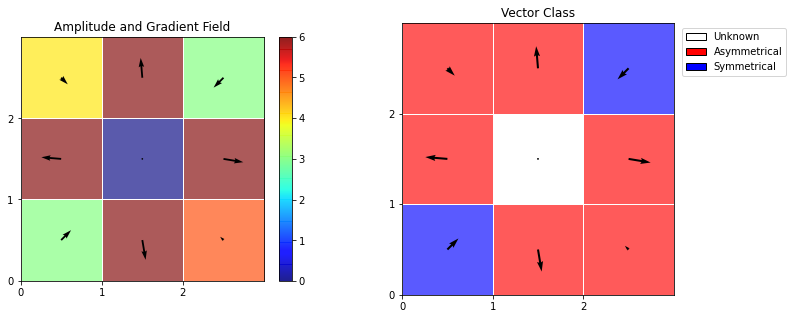

In [14]:
plotGPAVecClass(mat,ga)

In [15]:
mat = [[0,0,0],
       [2,0,2],
       [0,2,0]]
mat = np.array(mat).astype(np.float)
moments = ga.evaluate(mat, moment=['G1','G2','G3'],symmetrycalGrad=0)
print("Momentos do campo gradiente assimétrico:",np.round(moments,3))

moments = ga.evaluate(mat, moment=['G1','G2','G3'],symmetrycalGrad=1)
print("Momentos do campo gradiente simétrico:",np.round(moments,3))

Momentos do campo gradiente assimétrico: [0.333 0.997 1.049]
Momentos do campo gradiente simétrico: [0.   2.   1.25]


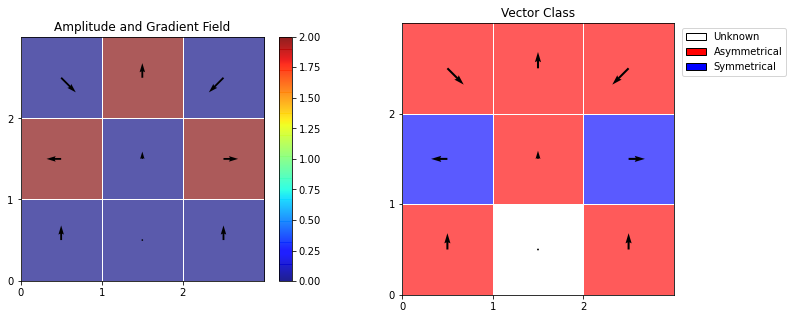

In [16]:
plotGPAVecClass(mat,ga)

## 3.4. Indeterminado

In [17]:
mat = [[0,0,0],
       [0,0,0],
       [0,0,0]]
mat = np.array(mat).astype(np.float)
moments = ga.evaluate(mat, moment=['G1','G2','G3'],symmetrycalGrad=0)
print("Momentos do campo gradiente assi:",np.round(moments,3))

moments = ga.evaluate(mat, moment=['G1','G2','G3'],symmetrycalGrad=1)
print("Momentos do campo gradiente simétrico:",np.round(moments,3))

Momentos do campo gradiente assi: [0. 0. 0.]
Momentos do campo gradiente simétrico: [0. 0. 0.]


# Referências

[1] Rosa, Reinaldo R., A. S. Sharma, and J. A. Valdivia. "Characterization of asymmetric fragmentation patterns in spatially extended systems." International Journal of Modern Physics C 10.01 (1999): 147-163.

[2] Barchi, P. H., et al. "Improving galaxy morphology with machine learning." arXiv preprint arXiv:1705.06818 (2017).